# Converter tf model to accelerator

In [ ]:
# Example using MNIST

import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
mean = np.mean(x_train)
std = np.std(x_train)
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

model = models.Sequential([
    layers.Conv2D(3, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.Conv2D(4, (3, 3), activation='relu'),
    layers.Conv2D(4, (3, 3), activation='relu'),
    layers.Conv2D(3, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(10, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

In [ ]:
# Training as usual
model.fit(x_train, y_train, epochs=30, batch_size=64, validation_data=(x_test, y_test))

test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')

In [ ]:
# Tflite quantization

def representative_dataset():
    for i in range(1000):
      yield [np.expand_dims(x_train[i].astype(np.float32) + np.random.normal(loc=2,scale=1,size=(28,28,1)).astype(np.float32), axis=0)]

converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  
converter.inference_output_type = tf.int8  
tflite_quant_mnist = converter.convert()

with open('cnn_mnist.tflite', 'wb') as f:
    f.write(tflite_quant_mnist)


interpreter = tf.lite.Interpreter(model_content = tflite_quant_mnist)
interpreter.allocate_tensors()

input_scale = interpreter.get_input_details()[0]['quantization_parameters']['scales']
bias_input = interpreter.get_input_details()[0]['quantization_parameters']['zero_points']

output_scale = interpreter.get_output_details()[0]['quantization_parameters']['scales']
bias_output = interpreter.get_output_details()[0]['quantization_parameters']['zero_points']

i = 120
output = interpreter.get_output_details()[0]  
input = interpreter.get_input_details()[0]  

input_data = tf.constant( tf.cast( x_test[i] / input_scale + bias_input, tf.int8), shape=[1, 28, 28, 1])
interpreter.set_tensor(input['index'], input_data)
interpreter.invoke()
output = interpreter.get_tensor(output['index'])
print((output - bias_output)*output_scale)
print(np.argmax((output - bias_output)*output_scale))
print(y_test[i])

In [28]:
# Conversion to accelerator

import helper as hp

i = 123
ifmap = x_test[i,:,:,:]
cnn_layers_amount = 4
fc_layers_amount = 2
hp.convert_model(ifmap, cnn_layers_amount, fc_layers_amount, model, interpreter)
print('digit:', y_test[i])

digit: 6


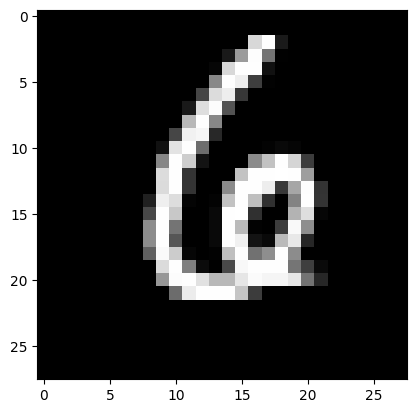

In [29]:
plt.imshow(x_test[i], cmap='gray')